In [346]:
#Importing libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from matplotlib.dates import DateFormatter, DayLocator
from pylab import rcParams
import pickle
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Data Preprocessing

In [397]:
df=pd.read_csv("Dataset.csv")  #Reading the dataset

df=df.drop(['VORJAHRESWERT','VERAEND_VORMONAT_PROZENT','VERAEND_VORJAHRESMONAT_PROZENT','ZWOELF_MONATE_MITTELWERT'],axis=1) #Removing unwanted columns

df.columns = ['Category','Accident_Type','Year','Month','Value'] #Renaming for ease

categories=set(list(df['Category'])) #Listing all categories

accidents=set(list(df['Accident_Type'])) #Listing all Accidents

# Removing unwanted rows

In [398]:
cond = df.Month == 'Summe' #Removing rows with sum of all values for each category

rows = df.loc[cond, :]

df.drop(rows.index, inplace=True)

# Changing date format

In [399]:
df['Month'] = pd.to_datetime(df['Month'],format='%Y%m')

# For category 1 (Alcohol Accidents)

In [400]:
df_alc = pd.DataFrame(columns=df.columns)

cond = df.Category == 'Alkoholunfälle'

rows = df.loc[cond, :]

df_alc = df_alc.append(rows, ignore_index=True)

df.drop(rows.index, inplace=True)

In [401]:
alcohol_acc=set(list(df_alc['Accident_Type']))

In [402]:
alcohol_stats=[]

for i in alcohol_acc:
    df_alc1 = pd.DataFrame(columns=df_alc.columns)
    cond = df_alc.Accident_Type == i
    rows = df_alc.loc[cond, :]
    df_alc1 = df_alc1.append(rows, ignore_index=True)
    alcohol_stats.append(df_alc1)

In [403]:
alcohol_stats

[           Category Accident_Type  Year      Month  Value
 0    Alkoholunfälle     insgesamt  2021 2021-01-01    NaN
 1    Alkoholunfälle     insgesamt  2021 2021-02-01    NaN
 2    Alkoholunfälle     insgesamt  2021 2021-03-01    NaN
 3    Alkoholunfälle     insgesamt  2021 2021-04-01    NaN
 4    Alkoholunfälle     insgesamt  2021 2021-05-01    NaN
 ..              ...           ...   ...        ...    ...
 259  Alkoholunfälle     insgesamt  2000 2000-08-01   77.0
 260  Alkoholunfälle     insgesamt  2000 2000-09-01   84.0
 261  Alkoholunfälle     insgesamt  2000 2000-10-01   83.0
 262  Alkoholunfälle     insgesamt  2000 2000-11-01   71.0
 263  Alkoholunfälle     insgesamt  2000 2000-12-01   85.0
 
 [264 rows x 5 columns],
            Category           Accident_Type  Year      Month  Value
 0    Alkoholunfälle  Verletzte und Getötete  2021 2021-01-01    NaN
 1    Alkoholunfälle  Verletzte und Getötete  2021 2021-02-01    NaN
 2    Alkoholunfälle  Verletzte und Getötete  2021 2021-03

# Verletzte und GetÃ¶tete

In [404]:
alcohol_stats[1] = alcohol_stats[1].set_index('Month')

alcohol_stats[1].index

y=alcohol_stats[1]['Value']

y=y['2020':]

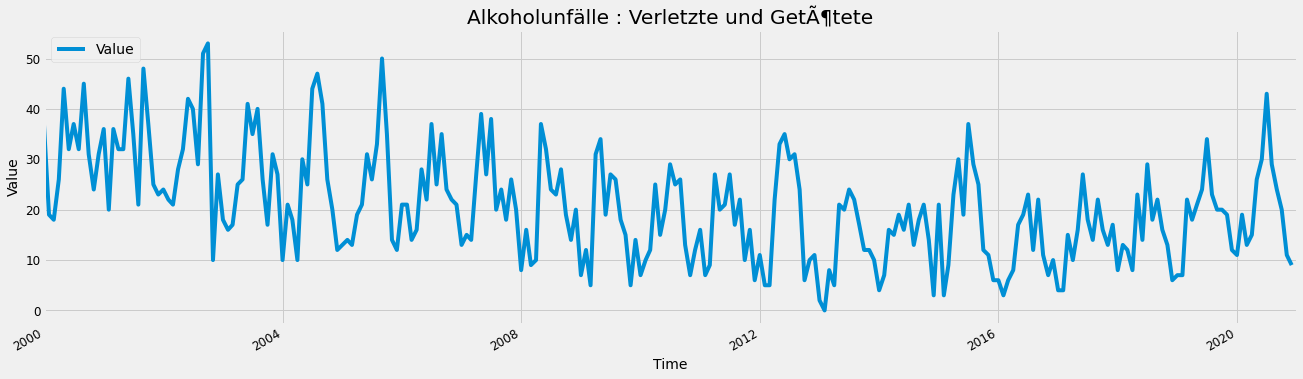

In [405]:
ax=y.plot(figsize=(20, 6))

ax.set_xlabel('Time')

ax.set_ylabel('Value')

ax.set_title('Alkoholunfälle : Verletzte und GetÃ¶tete')

ax.grid(True)

ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2021-01-01'))

ax.legend(loc='upper left');

plt.show()

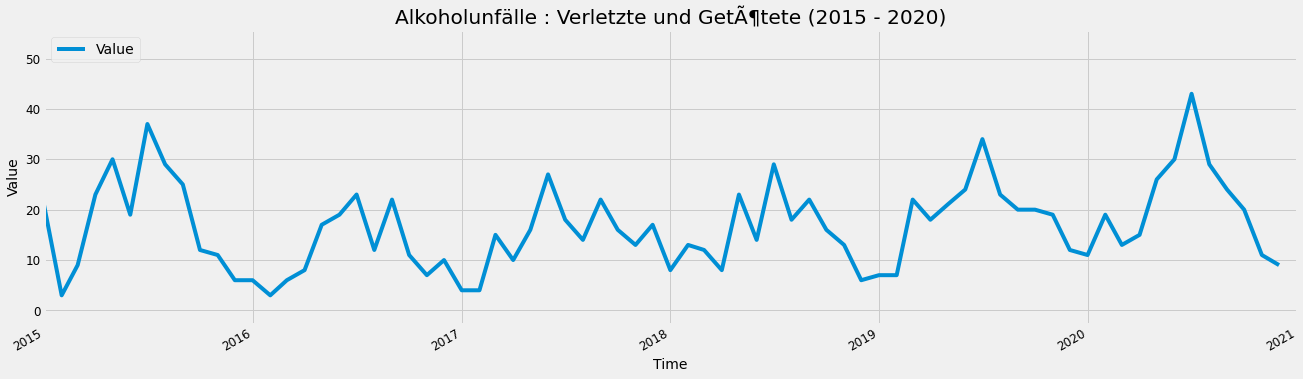

In [406]:
ax=y.plot(figsize=(20, 6))

ax.set_xlabel('Time')

ax.set_ylabel('Value')

ax.set_title('Alkoholunfälle : Verletzte und GetÃ¶tete (2015 - 2020)')

ax.grid(True)

ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2021-01-01'))

ax.legend(loc='upper left');

plt.show()

In [407]:
y.sort_index(inplace= True)

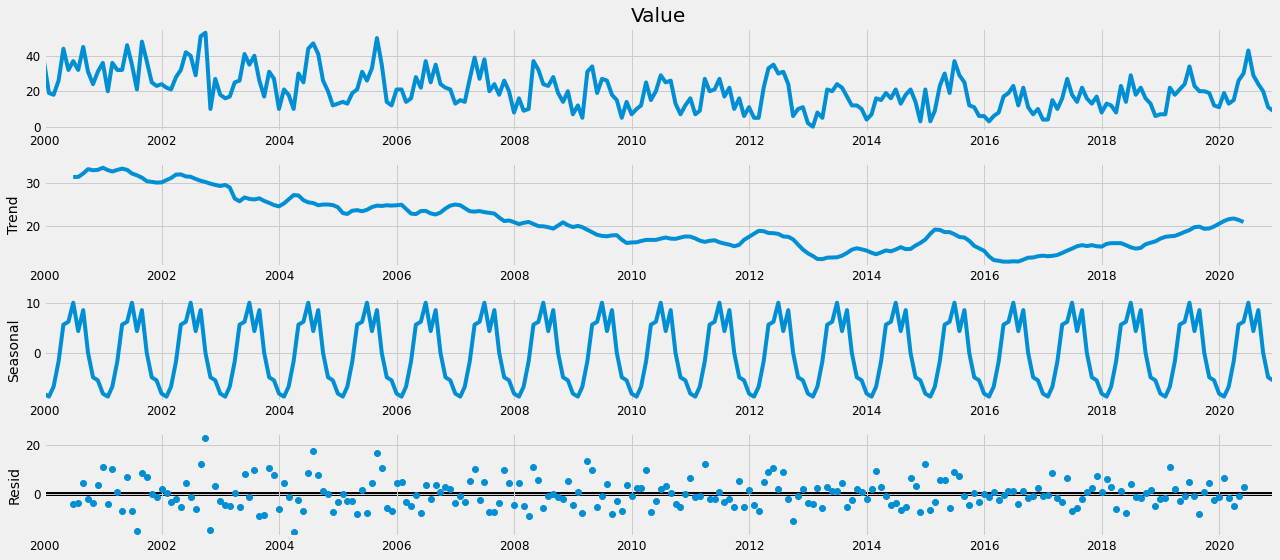

In [408]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')

fig = decomposition.plot()

plt.show()

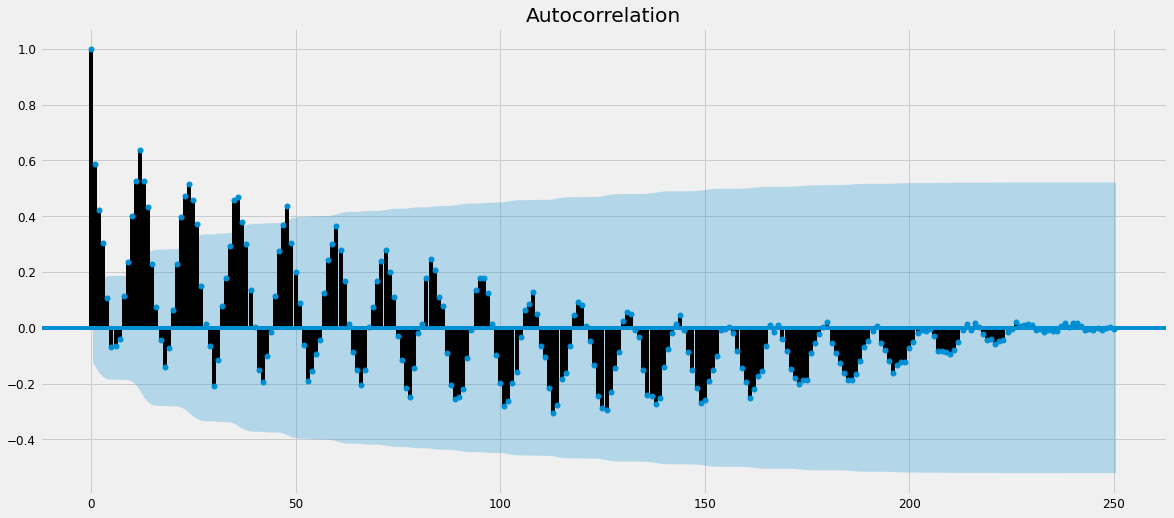

In [409]:
acf=plot_acf(y,lags=250)

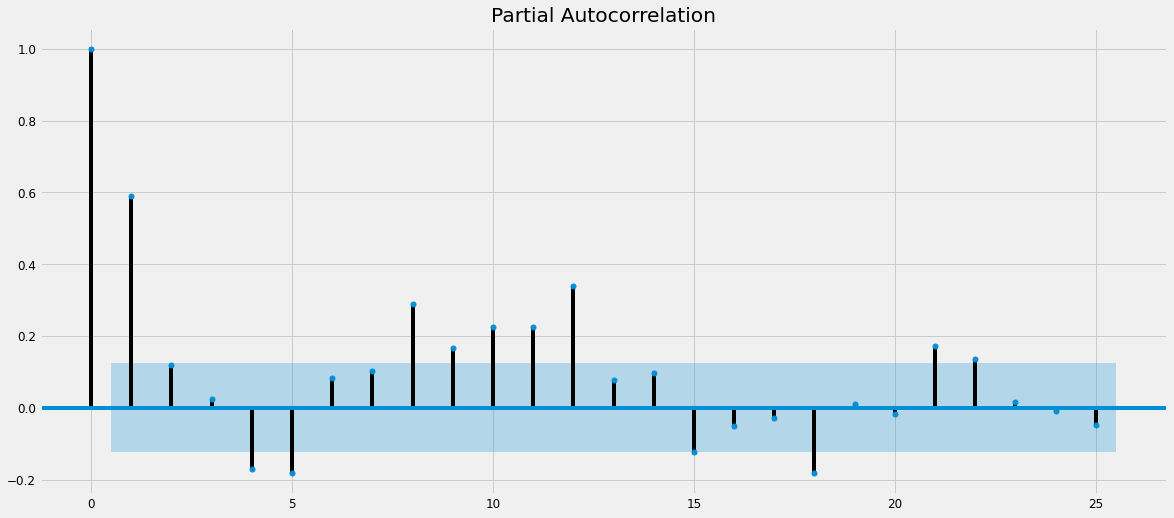

In [410]:
acf=plot_pacf(y)

In [411]:
y.index = pd.DatetimeIndex(y.index.values,freq=y.index.inferred_freq)

In [412]:
def test_stationarity(timeseries,maxlag):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
test_stationarity(dataset,maxlag=7)

Results of Dickey-Fuller Test:
Test Statistic                  -3.093
p-value                          0.027
#Lags Used                       7.000
Number of Observations Used    244.000
Critical Value (1%)             -3.457
Critical Value (5%)             -2.873
Critical Value (10%)            -2.573
dtype: float64


In [372]:
def sarimax(ts,all_param):
    results = []
    for param in all_param:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[12]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(y,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:1846.3
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:1743.83
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:1742.51
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:1809.09
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:1743.14
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:1744.12
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:1779.54
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:1742.69
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:1744.57
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:1710.22
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:1620.13
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:1619.47
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:1675.94
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:1620.12
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:1620.23
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:1643.26
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:1619.19
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:1621.19
Tried out S

In [121]:
best=float('inf')
best_order=0
best_seasonal_order=0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic<best:
                best=results.aic
                best_order=order
                best_seasonal_order=seasonal_order
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2549.776993447823
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2192.143622767375
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1959.2319699876193
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1746.6999490969301
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1618.1556883835945
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1496.8084188498688
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:1879.8173136948553
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1574.914759571087
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1421.6214828199197
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1736.4482275760556
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1662.0205905880164
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1563.6833830298606
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1619.865465909313
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1612.710380386979
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1484.644251875999
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1662.7926139868669
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1532.649759048579
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:1418.839143318498


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:1539.9312895863093
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:1500.2838921745133
ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:1502.1374998726797
ARIMA(0, 0, 1)x(2, 1, 2, 12)12 - AIC:1466.059475143316
ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:1477.6577111379263
ARIMA(0, 0, 1)x(2, 2, 1, 12)12 - AIC:1429.6520069784915
ARIMA(0, 0, 1)x(2, 2, 2, 12)12 - AIC:1403.6583521926282
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:2168.645436617454
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:1951.8650425957285
ARIMA(0, 0, 2)x(0, 0, 2, 12)12 - AIC:1770.8124068817706
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:1719.950142923534
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:1568.9694706686205
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:1455.762339562156
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:1854.1625072474774
ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:1548.7661877455703
ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:1393.8438932782594
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:1726.2207863408235


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:1629.9560194644214


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(1, 0, 2, 12)12 - AIC:1526.6505865744862
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:1597.725196516543
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1564.0273337021574
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:1454.8258749708
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:1656.8958359736741
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:1506.116967828165
ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:1392.0617681478411


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:1571.234093092176


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:1554.9869619103856
ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:1528.172161806191
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:1496.9917453649587
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:1498.8057975600768
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:1456.8833028933063
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:1479.1308305444381
ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:1429.1904740330674
ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:1393.090006129185
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1900.538666950541
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1759.9989811047294
ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:1638.1780267860786
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1823.819500370336
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1626.6191864813707
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:1506.6302269899888
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:1969.3987783305274
ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:1649.8380197195388
ARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:1474.512526528147
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1750.72825931248

ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:1520.1154560290586


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(0, 1, 2, 12)12 - AIC:1418.3807887757303
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:1866.0231823963513
ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:1558.3845212355382
ARIMA(0, 2, 2)x(0, 2, 2, 12)12 - AIC:1387.9625640952988
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:1705.8633319664539
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:1612.5430231459754


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 0, 2, 12)12 - AIC:1505.8669953287465
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:1585.4135631124855
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:1519.069932145658
ARIMA(0, 2, 2)x(1, 1, 2, 12)12 - AIC:1418.532769528816
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:1671.3298880808634
ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:1513.0224785751498


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(1, 2, 2, 12)12 - AIC:1388.0019591989824
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:1566.2748467307124


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:1536.1228727626883


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 0, 2, 12)12 - AIC:1511.7215713067224
ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:1456.507208081135


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:1438.5080644752275


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 1, 2, 12)12 - AIC:1422.2991914100917
ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:1486.6914750398846
ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:1417.8114433672135


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2)x(2, 2, 2, 12)12 - AIC:1390.0804944751067
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1903.2731963455283
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1766.86432371146
ARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:1639.6023508829674
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1731.8886949091911
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1581.2783145092012
ARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:1460.5967902017019
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:1872.347292053074
ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:1561.7814708266897
ARIMA(1, 0, 0)x(0, 2, 2, 12)12 - AIC:1408.8927740182405
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1708.3768995313944
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1637.3233248699862
ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:1541.3613651717992
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1585.8655768023991
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1577.5447140650863
ARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:1458.9667082120768
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:1625.9627658500447
ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:1519.306941901

c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:1524.6925590279948
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:1447.5795546613497
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:1445.635833504332
ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:1430.379439673682
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:1471.2456208273443
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:1405.94293491693
ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:1397.4415302428201
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:1842.2955885548936
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:1700.9694144491405
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:1564.8031470754072
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1720.6227638772082
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:1519.638434126262
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:1419.0949870130535
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:1843.531539732362
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:1549.538833281676


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:1384.2992924108523
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:1684.07891089121


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:1605.8607487713593


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:1508.3660791911775
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:1572.9356423384152
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:1518.154652485152
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:1418.025669046462
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:1629.8291602463487
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:1501.0673373262675


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:1384.4133135039624
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:1559.1924872649788


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:1524.0259966074398


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:1509.8650549871913
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:1445.9242942188775
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:1443.3256297392782


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:1420.0137129064897
ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:1472.9571162494744
ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:1406.2511809117218
ARIMA(1, 0, 2)x(2, 2, 2, 12)12 - AIC:1388.1482153560714
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1874.4228698610632
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1739.3470624808015
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:1616.0945255118002
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1793.1002242270529
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1599.2705397983686
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:1474.8941943636564
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:1941.1336735176938
ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:1624.6050547877298
ARIMA(1, 1, 0)x(0, 2, 2, 12)12 - AIC:1452.3492365766592
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1712.49852105328
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1678.737364059206
ARIMA(1, 1, 0)x(1, 0, 2, 12)12 - AIC:1566.4345324747608
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1624.861260574866
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1594.8054588268

c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:1546.076542648071


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:1717.1072890191626


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:1514.5698045383024


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:1414.4950262139873
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:1856.7721984065831


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:1548.0890992767077


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - AIC:1381.2266165362564


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:1665.086976365254


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:1604.837127666899
ARIMA(1, 2, 2)x(1, 0, 2, 12)12 - AIC:1503.412224551078


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:1568.5907034683487


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:1524.084786143594


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 1, 2, 12)12 - AIC:1410.768272176017


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:1651.3553139177293


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 2, 1, 12)12 - AIC:1552.5508452751287


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(1, 2, 2, 12)12 - AIC:1402.9852136501656


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:1539.132978145889


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:1522.0846546910063


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 0, 2, 12)12 - AIC:1505.2691432907868


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:1459.3713145163338


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 1, 12)12 - AIC:1470.519407205552


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 1, 2, 12)12 - AIC:1424.5121024460254
ARIMA(1, 2, 2)x(2, 2, 0, 12)12 - AIC:1472.574524674918


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 1, 12)12 - AIC:1412.1702640807166


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2)x(2, 2, 2, 12)12 - AIC:1391.604774596278
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:1872.2939586790808
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1744.4904962191795
ARIMA(2, 0, 0)x(0, 0, 2, 12)12 - AIC:1618.2007373853141
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:1725.9619507357802
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:1578.2458949677261
ARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:1452.57634551935
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:1865.2539134119074
ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:1563.7604120389042
ARIMA(2, 0, 0)x(0, 2, 2, 12)12 - AIC:1410.8810200710036
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:1703.5669807722109
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:1631.9135320726814
ARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:1538.3973294991915
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:1578.7958983253961
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:1566.0214163720666
ARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:1453.2222376307382
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:1620.8565559633942
ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:1513.143035768

c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:1838.587358703267


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:1703.6839010378194


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 0, 2, 12)12 - AIC:1568.1582204009055
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:1727.914596782717


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:1532.7510710473753


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 1, 2, 12)12 - AIC:1438.781193266074
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:1852.5565728667004
ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:1558.6898279144202


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(0, 2, 2, 12)12 - AIC:1395.4264394982165
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:1662.9651591864745
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:1612.775604140783


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 0, 2, 12)12 - AIC:1518.6287963562509


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:1576.8334271583064


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:1541.3417374349428


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 2, 12)12 - AIC:1446.6832574830833
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:1622.8132694610886
ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:1518.526920100789


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 2, 2, 12)12 - AIC:1396.5099744373124


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:1532.6893982641664


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:1518.3126877199354
ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:1520.237263125894


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:1438.231402635215


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:1439.7400758524645


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 1, 2, 12)12 - AIC:1446.8942543450166
ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:1466.0054857385153
ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC:1396.4983600996034


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 2, 2, 12)12 - AIC:1399.7323568302445
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:1865.2430929149614


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:1696.3307358195273


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 0, 2, 12)12 - AIC:1563.6934250140216
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:1721.093594319715
ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:1521.0673173972225


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 1, 2, 12)12 - AIC:1419.8738936545778
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:1844.7265249256784
ARIMA(2, 0, 2)x(0, 2, 1, 12)12 - AIC:1550.786522968592


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(0, 2, 2, 12)12 - AIC:1385.9240036573892
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:1664.4513579168417


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:1608.064180968468


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 0, 2, 12)12 - AIC:1510.1569607647525
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:1567.279752666394
ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:1522.5165874540853


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 2, 12)12 - AIC:1419.7042538594733
ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:1623.807008494991
ARIMA(2, 0, 2)x(1, 2, 1, 12)12 - AIC:1502.7945278347552
ARIMA(2, 0, 2)x(1, 2, 2, 12)12 - AIC:1386.5773821539988
ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:1552.3671556623985


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:1519.9324306811404


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:1510.7965970088176


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:1431.2761725233627
ARIMA(2, 0, 2)x(2, 1, 1, 12)12 - AIC:1429.6015876049796


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 1, 2, 12)12 - AIC:1422.136978400912
ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:1467.0471644966206
ARIMA(2, 0, 2)x(2, 2, 1, 12)12 - AIC:1397.9865835885826


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(2, 2, 2, 12)12 - AIC:1387.955118605179
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:1865.1460725377626
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:1733.3482074527992
ARIMA(2, 1, 0)x(0, 0, 2, 12)12 - AIC:1605.161297697939
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:1762.414190246434
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:1570.5550773124446
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:1450.678879326315
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:1901.950517888036
ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:1603.065741737155
ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC:1427.1209670852459
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:1693.317428272302
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:1649.9865709292496
ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC:1550.9584849640999
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:1588.4129329642776
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:1552.4737037999107
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:1452.6166168336085
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:1657.8804887850536
ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:1538.6407505481936

c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:1417.2346245209174
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:1866.2738724854926
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:1726.9264678750121
ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:1558.656286915245
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:1720.4424755003906
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:1525.6796525400773
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:1420.585049473912
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:1863.1065053351704
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:1553.7734191314908
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:1385.2554896715799
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:1658.6625749428126
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:1609.3420330697536
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:1508.1800545450708
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:1552.0637728632519
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:1523.2991558350818
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:1421.7197315934864
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:1624.2248604396486
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:1503.01589026

c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(2, 2, 2, 12)12 - AIC:1386.9278814855656
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:1830.0352337018317
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:1694.7747231892558
ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:1553.1480230231487
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:1710.0905256410406
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:1520.7274553300401
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:1417.4308464747319
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:1839.2490342716167
ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:1547.9134186755562
ARIMA(2, 1, 2)x(0, 2, 2, 12)12 - AIC:1378.5670922270892
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:1660.6620514507877
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:1603.4387756945425
ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:1502.167094274579
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:1551.36036775724
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:1517.1614396206744
ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:1418.407699181102
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:1623.8158572539737
ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:1495.5251297709

c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 0, 2, 12)12 - AIC:1504.0493584260396
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:1430.5220240431552
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:1428.5112710328601
ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:1423.174601673507
ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:1457.118481262363
ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:1392.5140447422714


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 2, 2, 12)12 - AIC:1379.9464879198854
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:1943.4017844903892
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:1808.298699358395
ARIMA(2, 2, 0)x(0, 0, 2, 12)12 - AIC:1676.9986592540276
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:1881.793727159236
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:1691.26061212395
ARIMA(2, 2, 0)x(0, 1, 2, 12)12 - AIC:1561.0293454498346
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:2011.6321798983022
ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:1709.9928648776227
ARIMA(2, 2, 0)x(0, 2, 2, 12)12 - AIC:1534.7186383071257
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:1785.3940404336208
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:1769.3117471561625
ARIMA(2, 2, 0)x(1, 0, 2, 12)12 - AIC:1661.1221070573565
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:1708.28163650287
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:1674.9087818683488
ARIMA(2, 2, 0)x(1, 1, 2, 12)12 - AIC:1562.839306540527
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:1763.9773733435707
ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:1657.6259873565102

c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 0, 2, 12)12 - AIC:1547.6371391391108


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:1720.8797114889878


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:1516.5931050869463


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:1415.8416394894855
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:1858.3130393864244
ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:1550.0659166093546
ARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:1383.7604124044226
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:1662.5972874293088


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:1605.7800835073554


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 0, 2, 12)12 - AIC:1505.309899209773
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:1559.1706242537225
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:1516.1257411728275


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC:1412.8682992190988


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:1644.5006970440031


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:1509.9894375875015


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC:1386.9344350484248


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:1526.624961894648


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:1512.804887140724


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC:1507.1769869633745


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:1434.2629056620713


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:1433.650628090718


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC:1427.9915770668395


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:1465.5291755003177


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:1406.8282079956532


c:\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:1390.6373547930532


# Best parameters

In [161]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,2),
                                seasonal_order=(0,2,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1375.8556685208441


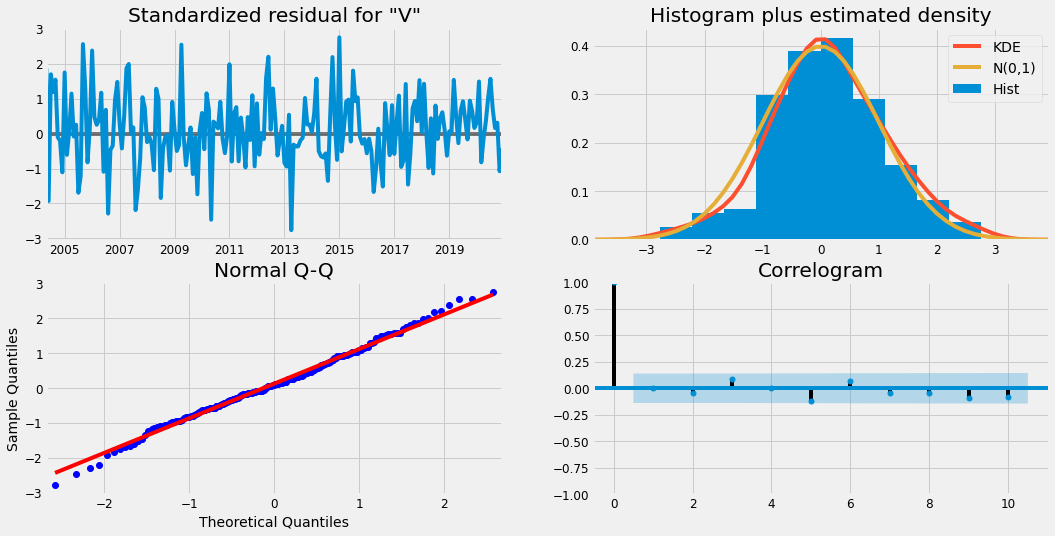

In [162]:
results.plot_diagnostics(figsize=(16, 8))

plt.show()

In [163]:
y

2000-01-01    37.0
2000-02-01    19.0
2000-03-01    18.0
2000-04-01    26.0
2000-05-01    44.0
              ... 
2020-08-01    29.0
2020-09-01    24.0
2020-10-01    20.0
2020-11-01    11.0
2020-12-01     9.0
Freq: MS, Name: Value, Length: 252, dtype: float64

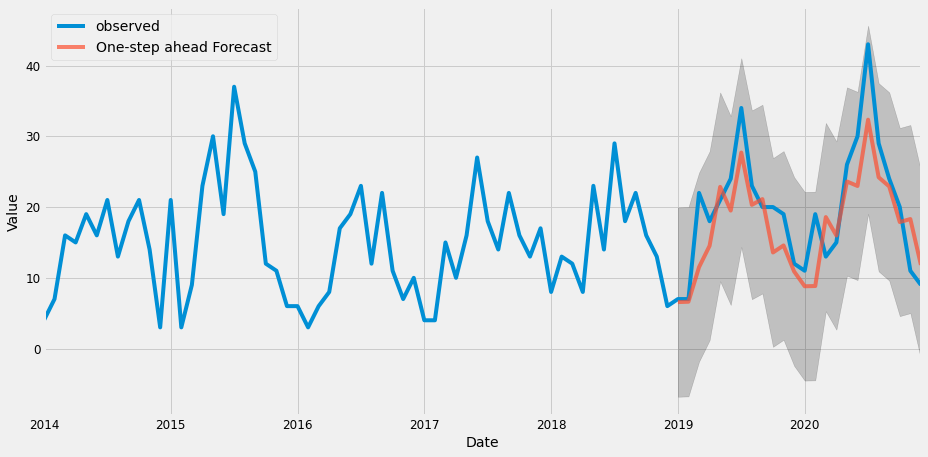

In [290]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)

pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')

ax.set_ylabel('Value')

plt.legend()

plt.show()

In [291]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27.29


In [292]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 5.22


# Saving the model

In [168]:
outfile=open("ARIMA_Alkoholunfälle_Verletzte.sav","wb")
pickle.dump(results,outfile)
outfile.close()

In [293]:
results.get_prediction('2021-01-01').predicted_mean

2021-01-01    10.780881
Freq: MS, dtype: float64

In [174]:
y['2020':]

2020-01-01    11.0
2020-02-01    19.0
2020-03-01    13.0
2020-04-01    15.0
2020-05-01    26.0
2020-06-01    30.0
2020-07-01    43.0
2020-08-01    29.0
2020-09-01    24.0
2020-10-01    20.0
2020-11-01    11.0
2020-12-01     9.0
Freq: MS, Name: Value, dtype: float64

# HWES

In [176]:
y

2000-01-01    37.0
2000-02-01    19.0
2000-03-01    18.0
2000-04-01    26.0
2000-05-01    44.0
              ... 
2020-08-01    29.0
2020-09-01    24.0
2020-10-01    20.0
2020-11-01    11.0
2020-12-01     9.0
Freq: MS, Name: Value, Length: 252, dtype: float64

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Value   No. Observations:                  228
Model:             ExponentialSmoothing   SSE                           9266.651
Optimized:                         True   AIC                            876.702
Trend:                         Additive   BIC                            931.571
Seasonal:                      Additive   AICC                           879.974
Seasonal Periods:                    12   Date:                 Thu, 15 Jul 2021
Box-Cox:                          False   Time:                         23:36:02
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0336941                alpha                 True
smoothing_trend          

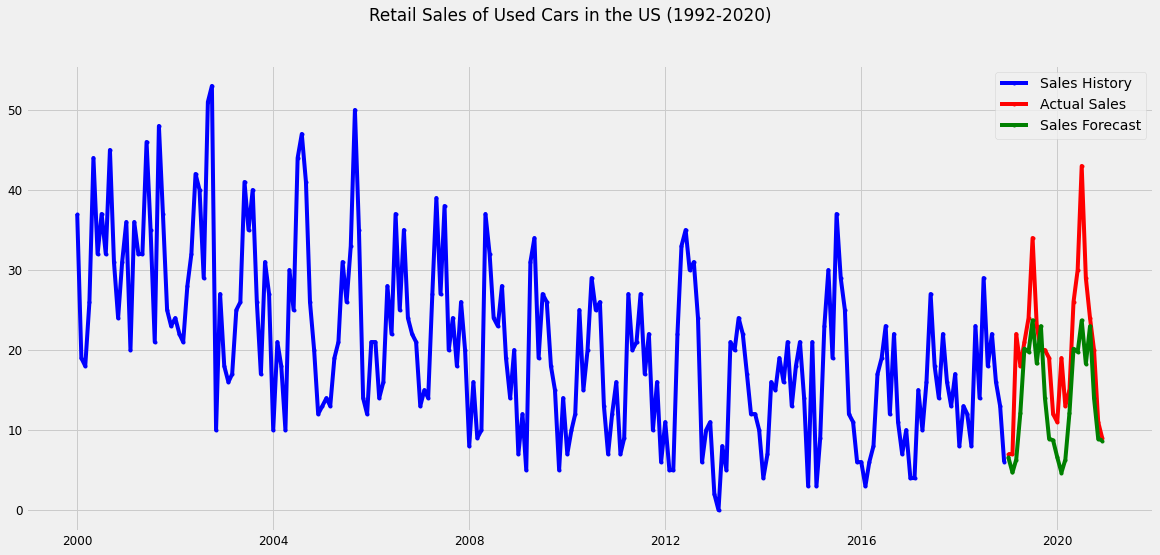

In [183]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

df_train = y.iloc[:-24]
df_test = y.iloc[-24:]

model = HWES(df_train, seasonal_periods=12,trend='add',seasonal='additive')
fitted = model.fit(optimized=True, use_brute=True)

#print out the training summary
print(fitted.summary())

#create an out of sample forcast for the next 12 steps beyond the final data point in the training data set
sales_forecast = fitted.forecast(steps=24)

#plot the training data, the test data and the forecast on the same plot
fig = plt.figure()
fig.suptitle('Retail Sales of Used Cars in the US (1992-2020)')
past, = plt.plot(df_train.index, df_train, 'b.-', label='Sales History')
future, = plt.plot(df_test.index, df_test, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(df_test.index, sales_forecast, 'g.-', label='Sales Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()


In [294]:
fitted.predict('2021-01-01')

2021-01-01    6.578403
Freq: MS, dtype: float64

In [185]:
sales_forecast

2019-01-01     6.610909
2019-02-01     4.698595
2019-03-01     6.313206
2019-04-01    12.185185
2019-05-01    20.169936
2019-06-01    19.783985
2019-07-01    23.708239
2019-08-01    18.320999
2019-09-01    22.983809
2019-10-01    14.012248
2019-11-01     8.942224
2019-12-01     8.703829
2020-01-01     6.594656
2020-02-01     4.682342
2020-03-01     6.296953
2020-04-01    12.168932
2020-05-01    20.153683
2020-06-01    19.767732
2020-07-01    23.691986
2020-08-01    18.304746
2020-09-01    22.967556
2020-10-01    13.995995
2020-11-01     8.925971
2020-12-01     8.687576
Freq: MS, dtype: float64

In [70]:
y_forecasted = sales_forecast
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 59.9


# DL

In [82]:
!pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


In [413]:
dataset=y

In [414]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split, StratifiedKFold

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = y
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(X, y):
# define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X_train, y_train, epochs=1000, verbose=0)
    # demonstrate prediction
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(scores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

62.53351593017578
88.85093688964844
66.3505859375
59.45398712158203
67.67766571044922
nan% (+/- nan%)


In [387]:
X_test.shape

(12, 2, 2, 1)

In [302]:
x_input = np.array(dataset[-4:])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

In [303]:
yhat

array([[29.5902]], dtype=float32)

In [223]:
y

Month
2020-01-01    11.0
2020-02-01    19.0
2020-03-01    13.0
2020-04-01    15.0
2020-05-01    26.0
              ... 
2000-08-01    32.0
2000-09-01    45.0
2000-10-01    31.0
2000-11-01    24.0
2000-12-01    31.0
Name: Value, Length: 252, dtype: float64

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
	model = Sequential()
	model.add(Dense(12, input_dim=8, activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# Fit the model
	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
	# evaluate the model
	scores = model.evaluate(X[test], Y[test], verbose=0)
	print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
	cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

# dickey fuller test

In [310]:
from statsmodels.tsa.stattools import adfuller

In [311]:
def test_stationarity(timeseries,maxlag):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

In [317]:
test_stationarity(dataset,maxlag=None)

Results of Dickey-Fuller Test:
Test Statistic                  -0.413
p-value                          0.908
#Lags Used                      11.000
Number of Observations Used    240.000
Critical Value (1%)             -3.458
Critical Value (5%)             -2.874
Critical Value (10%)            -2.573
dtype: float64
